<a href="https://colab.research.google.com/github/emiletimothy/Caltech-CS155-2023/blob/main/set4/prob2_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pandas as pd
import seaborn as sns

## Model Setup

In [ ]:
model = nn.Sequential(nn.Linear(9, 5),
                    nn.Linear(5, 2),
                    nn.Softmax(dim=1))

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# binary classification problem, so BCELoss is the best choice
loss_fn = nn.BCELoss()


Sequential(
  (0): Linear(in_features=9, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=2, bias=True)
  (2): Softmax(dim=1)
)


## Data Setup

In [ ]:
# data preprocessing


df = pd.read_csv("COVID-19_Case_Surveillance_Public_Use_Data_Subset.csv")

# only need rows with non-missing target value
df = df[df["death_yn"].isin(["Yes", "No"])]

# don't need cols with majority missing values
df = df.drop(['icu_yn', 'medcond_yn'], axis=1)

# date rows into numeric form
date_cols = ['cdc_case_earliest_dt ', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt']
for date_col in date_cols:
    df[date_col] = pd.to_datetime(df[date_col], infer_datetime_format=True).astype('int64')
    df[date_col] = df[date_col]  / df[date_col].abs().max()

# factorize categorical columns 
cat_cols = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'death_yn']
for cat_col in cat_cols:
    df[cat_col] = pd.factorize(df[cat_col])[0]

# shuffle dataset
df = df.sample(frac=1)

# sanity check
df.describe()


<ipython-input-14-ad4f9dcaae31>:15: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  df[date_col] = pd.to_datetime(df[date_col], infer_datetime_format=True).astype('int64')


,Unnamed: 0,cdc_case_earliest_dt,cdc_report_dt,pos_spec_dt,onset_dt,current_status,sex,age_group,race_ethnicity_combined,hosp_yn,death_yn
count,259715.000000,259715.000000,259715.000000,259715.000000,259715.000000,259715.000000,259715.000000,259715.000000,259715.000000,259715.000000,259715.000000
mean,400254.108196,0.973826,0.976256,-1.757605,-2.495756,0.164754,0.555351,3.376998,1.771915,0.707787,0.026159
std,230797.097038,0.012740,0.012037,3.203803,3.235140,0.370959,0.552555,2.096839,1.273895,0.959862,0.159610
min,0.000000,0.943529,0.943564,-5.514334,-5.515474,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,200866.000000,0.962284,0.965302,-5.514334,-5.515474,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000
50%,400311.000000,0.975924,0.979346,0.959709,-5.515474,0.000000,1.000000,3.000000,1.000000,0.000000,0.000000
75%,600097.500000,0.982227,0.983580,0.980319,0.966262,0.000000,1.000000,5.000000,3.000000,2.000000,0.000000
max,799996.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,9.000000,8.000000,3.000000,1.000000


In [ ]:
# accounting for data imbalance

# separate data set aside for training
train_df = df.iloc[:220892]

# separate training data into classifications
train_df_1 = train_df[train_df["death_yn"] == 1]
train_df_0 = train_df[train_df["death_yn"] == 0]

# recombine with a much smaller proportion of 0 death_yn rows
# leaving a 1:5 data imbalance instead of ~98:2
train_df = pd.concat([train_df_1, train_df_0.iloc[:len(train_df_1) * 5]])

# shuffle again
train_df = train_df.sample(frac=1)

X = train_df.drop(['death_yn', 'Unnamed: 0'], axis=1)
y = train_df['death_yn']

print(len(X))

34410


In [ ]:
# do not balance testing data
Xt = df.drop(['death_yn', 'Unnamed: 0'], axis=1).iloc[220892:]
yt = df['death_yn'].iloc[220892:]

# making into torch tensors

X_tensor = torch.from_numpy(X.values).float()
Xt_tensor = torch.from_numpy(Xt.values).float()

y_tensor = F.one_hot(torch.from_numpy(y.values)).float()
yt_tensor = F.one_hot(torch.from_numpy(yt.values)).float()

# make datasets and dataloaders

train_dataset = TensorDataset(X_tensor, y_tensor)
test_dataset = TensorDataset(Xt_tensor, yt_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True) 


## Training Loop

In [ ]:
# Some layers, such as Dropout, behave differently during training
model.train()

for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        # Erase accumulated gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate loss
        loss = loss_fn(output, target)

        # Backward pass
        loss.backward()
        
        # Weight update
        optimizer.step()

        break

    # Track loss each epoch
    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

Train Epoch: 1  Loss: 0.5341
Train Epoch: 2  Loss: 0.6181
Train Epoch: 3  Loss: 0.5594
Train Epoch: 4  Loss: 0.3565
Train Epoch: 5  Loss: 0.2558
Train Epoch: 6  Loss: 0.2941
Train Epoch: 7  Loss: 0.4341
Train Epoch: 8  Loss: 0.6242
Train Epoch: 9  Loss: 0.3733
Train Epoch: 10  Loss: 0.4663
Train Epoch: 11  Loss: 0.6345
Train Epoch: 12  Loss: 0.3277
Train Epoch: 13  Loss: 0.4517
Train Epoch: 14  Loss: 0.3253
Train Epoch: 15  Loss: 0.6741
Train Epoch: 16  Loss: 0.5799
Train Epoch: 17  Loss: 0.5828
Train Epoch: 18  Loss: 0.5329
Train Epoch: 19  Loss: 0.3256
Train Epoch: 20  Loss: 0.4280


## Testing Loop

In [ ]:
# Putting layers like Dropout into evaluation mode
model.eval()

test_loss = 0
correct = 0

# Turning off automatic differentiation
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        test_loss += loss_fn(output.squeeze(), target.squeeze()).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=False)  # Get the index of the max class score
        correct += pred.eq(target.argmax(dim=1, keepdim=False).view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Test set: Average loss: 0.0080, Accuracy: 37764/38823 (97.2722)


## Weight Matrix Visualization

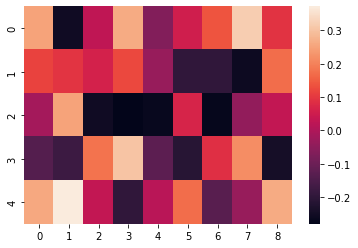

In [ ]:
weights = model.state_dict()['0.weight']

sns.heatmap(weights)

## 2-Layer Linear Model

In [ ]:
model2 = nn.Sequential(nn.Linear(9, 5),
                       nn.Linear(5, 5),
                       nn.Linear(5, 2),
                       nn.Softmax(dim=1))

optimizer2 = torch.optim.Adam(model2.parameters(), lr=1e-3)

print(model2)

# Same training and testing loops
model2.train()
for epoch in range(20):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer2.zero_grad()
        output = model2(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer2.step()

    print('Train Epoch: %d  Loss: %.4f' % (epoch + 1,  loss.item()))

model2.eval()

test_loss = 0
correct = 0

with torch.no_grad():
    for data, target in test_loader:
        output = model2(data)
        test_loss += loss_fn(output.squeeze(), target).item()  # Sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max class score
        correct += pred.eq(target.argmax(dim=1, keepdim=True).view_as(pred)).sum().item()

test_loss /= len(test_loader.dataset)

print('Test set: Average loss: %.4f, Accuracy: %d/%d (%.4f)' %
      (test_loss, correct, len(test_loader.dataset),
       100. * correct / len(test_loader.dataset)))

Sequential(
  (0): Linear(in_features=9, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=5, bias=True)
  (2): Linear(in_features=5, out_features=2, bias=True)
  (3): Softmax(dim=1)
)
Train Epoch: 1  Loss: 0.4641
Train Epoch: 2  Loss: 0.8944
Train Epoch: 3  Loss: 0.4328
Train Epoch: 4  Loss: 0.3761
Train Epoch: 5  Loss: 0.2581
Train Epoch: 6  Loss: 0.0712
Train Epoch: 7  Loss: 0.3082
Train Epoch: 8  Loss: 0.4761
Train Epoch: 9  Loss: 0.1783
Train Epoch: 10  Loss: 0.2534
Train Epoch: 11  Loss: 0.1623
Train Epoch: 12  Loss: 0.3572
Train Epoch: 13  Loss: 0.2141
Train Epoch: 14  Loss: 0.4104
Train Epoch: 15  Loss: 0.4796
Train Epoch: 16  Loss: 0.1172
Train Epoch: 17  Loss: 0.4619
Train Epoch: 18  Loss: 0.1892
Train Epoch: 19  Loss: 0.1924
Train Epoch: 20  Loss: 0.2723
Test set: Average loss: 0.0050, Accuracy: 37078/38823 (95.5052)
